In [303]:
import torch
import os
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F

In [304]:
def save_torch_tensor(tensor, filename='tensor.pt'):
    save_dir = os.path.expanduser('~/Downloads/saved_tensors')
    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, filename)
    torch.save(tensor, file_path)
    print(f"Saved tensor to {file_path}")
def load_torch_tensor(filename='tensor.pt'):
    load_path = os.path.join(os.path.expanduser('~/Downloads/saved_tensors'), filename)
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"No tensor file found at {load_path}")
    tensor = torch.load(load_path, map_location=torch.device('cpu'))
    print(f"Loaded tensor from {load_path}")
    return tensor

In [305]:
target_binned = load_torch_tensor()
target_binned.to('mps')

Loaded tensor from /Users/jan/Downloads/saved_tensors/tensor.pt


tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 

In [306]:
# import torch
# import torch.nn.functional as F
# 
# def dlbd(input_tensor, output_size, sigma=1.0):
#     """
#     Sped up version using two 1D convolutions (vertical then horizontal).
#     input_tensor shape: (B, C, H, W), one-hot
#     output_size: desired output size (int or tuple (desired_H, desired_W)); must be smaller than input.
#     sigma: standard deviation of the gaussian
#     """
#     input_tensor = input_tensor.float()
#     B, C, H, W = input_tensor.shape
# 
#     if isinstance(output_size, int):
#         desired_H = desired_W = output_size
#     else:
#         desired_H, desired_W = output_size
# 
#     assert desired_H < H and desired_W < W, "Desired output size must be smaller than input dimensions."
# 
#     # Determine kernel sizes for valid convolution:
#     kernel_h = H - desired_H + 1
#     kernel_w = W - desired_W + 1
#     print(f"Using kernel size: ({kernel_h}, {kernel_w})")
# 
#     # Create vertical 1D Gaussian kernel (shape: (kernel_h, 1))
#     coords_h = torch.arange(kernel_h, device=input_tensor.device, dtype=input_tensor.dtype) - kernel_h // 2
#     g_1d_h = torch.exp(-(coords_h**2) / (2 * sigma**2))
#     g_1d_h /= g_1d_h.sum()
#     # Reshape to (C, 1, kernel_h, 1) for depthwise conv
#     g_1d_h = g_1d_h.view(1, 1, kernel_h, 1).repeat(C, 1, 1, 1)
# 
#     # First, convolve vertically (no padding)
#     out = F.conv2d(input_tensor, g_1d_h, groups=C, padding=0)
# 
#     # Create horizontal 1D Gaussian kernel (shape: (1, kernel_w))
#     coords_w = torch.arange(kernel_w, device=input_tensor.device, dtype=input_tensor.dtype) - kernel_w // 2
#     g_1d_w = torch.exp(-(coords_w**2) / (2 * sigma**2))
#     g_1d_w /= g_1d_w.sum()
#     # Reshape to (C, 1, 1, kernel_w)
#     g_1d_w = g_1d_w.view(1, 1, 1, kernel_w).repeat(C, 1, 1, 1)
# 
#     # Then, convolve horizontally (again, no padding)
#     out = F.conv2d(out, g_1d_w, groups=C, padding=0)
#     return out

In [307]:
import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F


def dlbd_traget_pre_processing(input_tensor, output_size, sigma=1.0, kernel_size=None):
    """
    Sped up version using two 1D convolutions (vertical then horizontal) that always produces the desired output size.
    
    When kernel_size is None, the maximum allowed odd kernel is used so that no cropping is needed.
    When a manual (odd) kernel_size is provided (and it's smaller than the maximum), the input is center-cropped
    so that the valid convolution produces exactly the desired output size. This can save compute.
    
    Args:
        input_tensor (torch.Tensor): Shape (B, C, H, W), one-hot.
        output_size (int or tuple): Desired output size (int or (desired_H, desired_W)); must be smaller than input.
        sigma (float): Standard deviation of the Gaussian.
        kernel_size (int or tuple, optional): Manual kernel size. Must be <= maximal kernel size 
            (computed as H - desired_H + 1 and W - desired_W + 1) and must be odd.
            If None, kernel sizes are computed automatically.
    
    Returns:
        torch.Tensor: Output after convolution with shape (B, C, desired_H, desired_W).
    """
    input_tensor = input_tensor.float()
    B, C, H, W = input_tensor.shape

    if isinstance(output_size, int):
        desired_H = desired_W = output_size
    else:
        desired_H, desired_W = output_size

    assert desired_H < H and desired_W < W, "Desired output size must be smaller than input dimensions."

    # Maximum allowed kernel sizes for valid convolution:
    max_kernel_h = H - desired_H + 1
    max_kernel_w = W - desired_W + 1

    if kernel_size is None:
        # Use the maximum allowed odd kernel sizes.
        kernel_h = max_kernel_h if max_kernel_h % 2 == 1 else max_kernel_h - 1
        kernel_w = max_kernel_w if max_kernel_w % 2 == 1 else max_kernel_w - 1
        # No cropping needed: (H - kernel_h + 1 == desired_H)
    else:
        # Use manual kernel size.
        if isinstance(kernel_size, int):
            kernel_h = kernel_w = kernel_size
        elif isinstance(kernel_size, (tuple, list)) and len(kernel_size) == 2:
            kernel_h, kernel_w = kernel_size
        else:
            raise ValueError("kernel_size must be an int or a tuple/list of two ints.")

        if kernel_h > max_kernel_h or kernel_w > max_kernel_w:
            raise ValueError(f"Manual kernel size ({kernel_h}, {kernel_w}) exceeds the maximum allowed "
                             f"({max_kernel_h}, {max_kernel_w}).")
        if kernel_h % 2 == 0 or kernel_w % 2 == 0:
            raise ValueError(f"Kernel sizes must be odd numbers. Got ({kernel_h}, {kernel_w}).")
        # Center-crop the input so that after valid convolution with manual kernel the output size is desired.
        crop_H = desired_H + kernel_h - 1  # because output height = cropped_H - kernel_h + 1
        crop_W = desired_W + kernel_w - 1
        offset_H = (H - crop_H) // 2
        offset_W = (W - crop_W) // 2
        input_tensor = input_tensor[:, :, offset_H:offset_H+crop_H, offset_W:offset_W+crop_W]
        # Update H, W for clarity (not strictly needed)
        H, W = crop_H, crop_W

    print(f"Using kernel size: ({kernel_h}, {kernel_w})")

    # Create vertical 1D Gaussian kernel (shape: (kernel_h, 1))
    coords_h = torch.arange(kernel_h, device=input_tensor.device, dtype=input_tensor.dtype) - kernel_h // 2
    g_1d_h = torch.exp(-(coords_h**2) / (2 * sigma**2))
    g_1d_h /= g_1d_h.sum()
    # Reshape to (C, 1, kernel_h, 1) for depthwise convolution
    g_1d_h = g_1d_h.view(1, 1, kernel_h, 1).repeat(C, 1, 1, 1)

    # Convolve vertically (valid convolution)
    out = F.conv2d(input_tensor, g_1d_h, groups=C, padding=0)

    # Create horizontal 1D Gaussian kernel (shape: (1, kernel_w))
    coords_w = torch.arange(kernel_w, device=input_tensor.device, dtype=input_tensor.dtype) - kernel_w // 2
    g_1d_w = torch.exp(-(coords_w**2) / (2 * sigma**2))
    g_1d_w /= g_1d_w.sum()
    # Reshape to (C, 1, 1, kernel_w) for depthwise convolution
    g_1d_w = g_1d_w.view(1, 1, 1, kernel_w).repeat(C, 1, 1, 1)

    # Convolve horizontally (valid convolution)
    out = F.conv2d(out, g_1d_w, groups=C, padding=0)
    return out

In [308]:
blurred = dlbd_traget_pre_processing(target_binned, output_size=32, sigma=1, kernel_size=25)
blurred.shape

Using kernel size: (25, 25)


torch.Size([4, 32, 32, 32])

In [309]:
print(f'target binned: {target_binned[0, :, 16, 16]}')
print(f'blurred: {blurred[0, :, 16, 16]}')


target binned: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
blurred: tensor([1.5495e-04, 2.0618e-02, 1.0498e-01, 2.3314e-01, 3.6277e-01, 2.7834e-01,
        3.6040e-07, 4.6934e-21, 2.8356e-31, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00])


In [310]:
target_binned = T.CenterCrop(size=32)(target_binned)
target_winner_bin = torch.argmax(target_binned, dim=1)
blurred_winner_bin = torch.argmax(blurred, dim=1)


In [311]:
blurred.shape

torch.Size([4, 32, 32, 32])

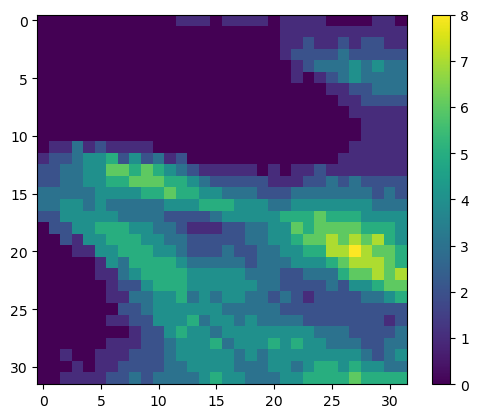

In [312]:
plot_batch = 0
plt.imshow(target_winner_bin[plot_batch, :, :])
plt.colorbar()
plt.show()

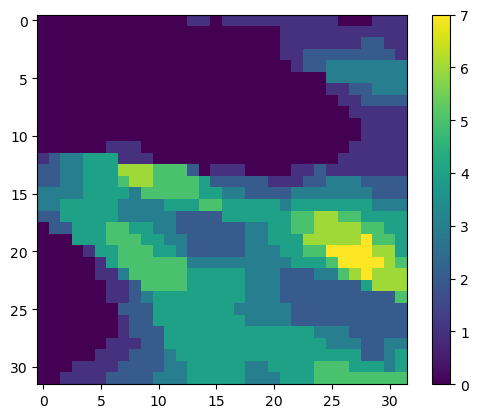

In [313]:
plot_batch = 0
plt.imshow(blurred_winner_bin[plot_batch, :, :])
plt.colorbar()
plt.show()

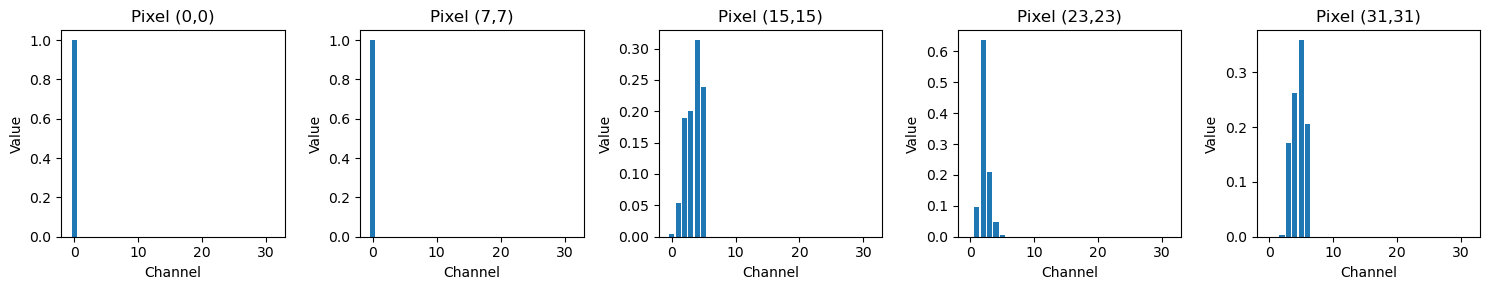

In [314]:
import matplotlib.pyplot as plt
import numpy as np

# Assume 'blurred' is a torch.Tensor of shape (B, C, H, W)
plot_batch = 0
B, C, H, W = blurred.shape

# Sample 5 pixels along the top-left to bottom-right diagonal
diagonal_indices = np.linspace(0, H - 1, 5, dtype=int)  # assuming H == W

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(diagonal_indices):
    # Get the channel probabilities at pixel (idx, idx)
    hist = blurred[plot_batch, :, idx, idx].cpu().numpy()
    axes[i].bar(np.arange(C), hist)
    axes[i].set_title(f"Pixel ({idx},{idx})")
    axes[i].set_xlabel("Channel")
    axes[i].set_ylabel("Value")

plt.tight_layout()
plt.show()

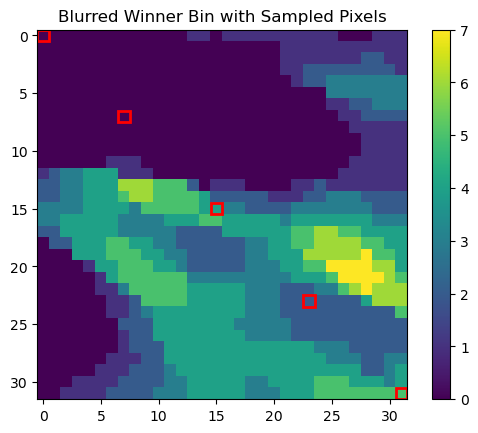

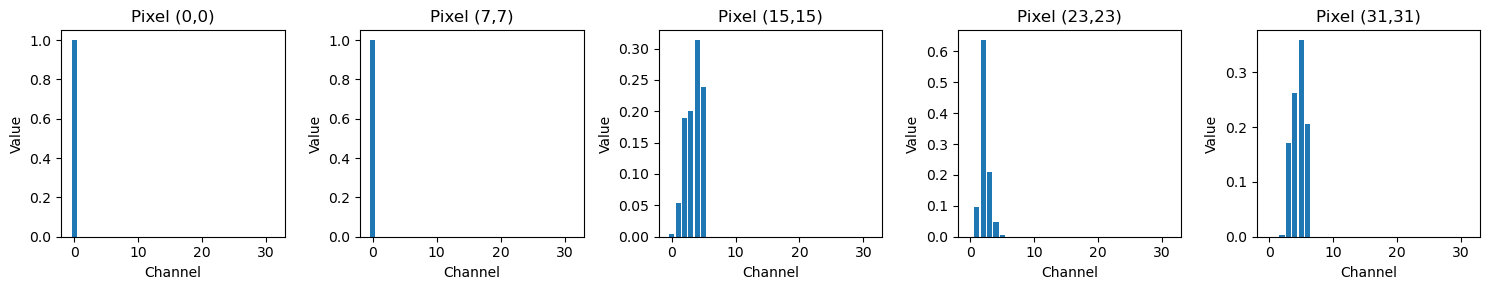

In [315]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

plot_batch = 0
# Assuming blurred_winner_bin shape: (B, H, W) and blurred shape: (B, C, H, W)
B, H, W = blurred_winner_bin.shape[0], blurred_winner_bin.shape[1], blurred_winner_bin.shape[2]
_, C, _, _ = blurred.shape

# Sample 5 pixels along the diagonal (top-left to bottom-right)
diagonal_indices = np.linspace(0, H - 1, 5, dtype=int)

# Display the image with red frames around the sampled pixels
fig, ax = plt.subplots()
im = ax.imshow(blurred_winner_bin[plot_batch, :, :])
plt.colorbar(im, ax=ax)
for idx in diagonal_indices:
    # The rectangle is drawn with a half pixel offset to frame the pixel exactly
    rect = patches.Rectangle((idx - 0.5, idx - 0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
plt.title("Blurred Winner Bin with Sampled Pixels")
plt.show()

# Plot the histograms for each sampled pixel
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(diagonal_indices):
    hist = blurred[plot_batch, :, idx, idx].cpu().numpy()
    axes[i].bar(np.arange(C), hist)
    axes[i].set_title(f"Pixel ({idx},{idx})")
    axes[i].set_xlabel("Channel")
    axes[i].set_ylabel("Value")
plt.tight_layout()
plt.show()

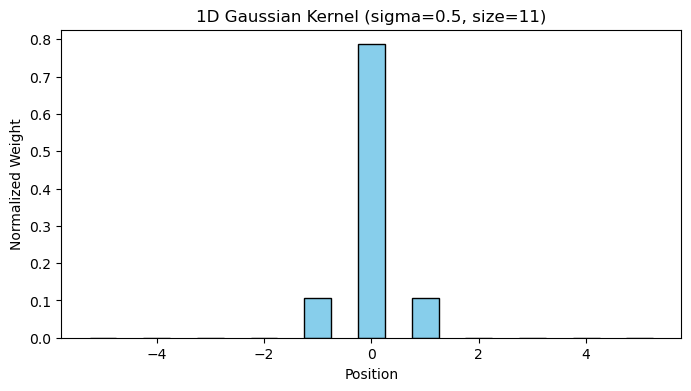

In [316]:
import torch
import matplotlib.pyplot as plt

def plot_1d_gaussian(sigma, kernel_size=11):
    """
    Visualizes the 1D Gaussian distribution used in the dlbd function.
    
    Args:
        sigma (float): Standard deviation of the Gaussian.
        kernel_size (int, optional): Size of the kernel. If None, defaults to 6*sigma+1 (rounded to odd).
    """
    if kernel_size is None:
        kernel_size = int(6 * sigma + 1)
        if kernel_size % 2 == 0:
            kernel_size += 1

    # Create centered coordinates
    coords = torch.arange(kernel_size, dtype=torch.float32) - kernel_size // 2

    # Compute the 1D Gaussian
    g_1d = torch.exp(-(coords**2) / (2 * sigma**2))
    g_1d /= g_1d.sum()  # normalize

    # Plot as a histogram (bar plot)
    plt.figure(figsize=(8, 4))
    plt.bar(coords.numpy(), g_1d.numpy(), width=0.5, color='skyblue', edgecolor='black')
    plt.xlabel("Position")
    plt.ylabel("Normalized Weight")
    plt.title(f"1D Gaussian Kernel (sigma={sigma}, size={kernel_size})")
    plt.show()

# Example usage:
plot_1d_gaussian(sigma=0.5)

In [317]:
\# Test the original vs. the sped-up fucntion

import torch
import torch.nn.functional as F
import numpy as np

def dlbd_original(input_tensor, output_size, sigma=1.0):
    """
    Original version using one 2D convolution.
    input_tensor shape: (B, C, H, W)
    output_size: desired output size (int or tuple (desired_H, desired_W))
    """
    input_tensor = input_tensor.float()
    B, C, H, W = input_tensor.shape

    if isinstance(output_size, int):
        desired_H = desired_W = output_size
    else:
        desired_H, desired_W = output_size

    assert desired_H < H and desired_W < W, "Desired output size must be smaller than input dimensions."
    kernel_h = H - desired_H + 1
    kernel_w = W - desired_W + 1
    print(f"[Original] Using kernel size: ({kernel_h}, {kernel_w})")

    # Create 1D gaussian kernels for height and width
    coords_h = torch.arange(kernel_h, device=input_tensor.device, dtype=input_tensor.dtype) - kernel_h // 2
    g_1d_h = torch.exp(-(coords_h**2) / (2 * sigma**2))
    g_1d_h /= g_1d_h.sum()

    coords_w = torch.arange(kernel_w, device=input_tensor.device, dtype=input_tensor.dtype) - kernel_w // 2
    g_1d_w = torch.exp(-(coords_w**2) / (2 * sigma**2))
    g_1d_w /= g_1d_w.sum()

    # Form the 2D gaussian kernel
    g_2d = g_1d_h[:, None] * g_1d_w[None, :]
    g_2d = g_2d.view(1, 1, kernel_h, kernel_w)
    g_2d = g_2d.repeat(C, 1, 1, 1)

    return F.conv2d(input_tensor, g_2d, groups=C, padding=0)

def dlbd_separable(input_tensor, output_size, sigma=1.0):
    """
    Sped up version using two 1D convolutions (vertical then horizontal).
    input_tensor shape: (B, C, H, W)
    output_size: desired output size (int or tuple (desired_H, desired_W))
    """
    input_tensor = input_tensor.float()
    B, C, H, W = input_tensor.shape

    if isinstance(output_size, int):
        desired_H = desired_W = output_size
    else:
        desired_H, desired_W = output_size

    assert desired_H < H and desired_W < W, "Desired output size must be smaller than input dimensions."
    kernel_h = H - desired_H + 1
    kernel_w = W - desired_W + 1
    print(f"[Separable] Using kernel size: ({kernel_h}, {kernel_w})")

    # Vertical convolution
    coords_h = torch.arange(kernel_h, device=input_tensor.device, dtype=input_tensor.dtype) - kernel_h // 2
    g_1d_h = torch.exp(-(coords_h**2) / (2 * sigma**2))
    g_1d_h /= g_1d_h.sum()
    g_1d_h = g_1d_h.view(1, 1, kernel_h, 1).repeat(C, 1, 1, 1)
    out = F.conv2d(input_tensor, g_1d_h, groups=C, padding=0)

    # Horizontal convolution
    coords_w = torch.arange(kernel_w, device=input_tensor.device, dtype=input_tensor.dtype) - kernel_w // 2
    g_1d_w = torch.exp(-(coords_w**2) / (2 * sigma**2))
    g_1d_w /= g_1d_w.sum()
    g_1d_w = g_1d_w.view(1, 1, 1, kernel_w).repeat(C, 1, 1, 1)
    out = F.conv2d(out, g_1d_w, groups=C, padding=0)

    return out

# --- Test Code ---

# Assuming you have a tensor called target_binned. 
# For testing, if not defined, create a dummy one-hot tensor of shape (B, C, H, W)
if 'target_binned' not in globals():
    B, C, H, W = 1, 32, 256, 256
    target_binned = torch.zeros(B, C, H, W)
    # Fill with one-hot encoding: each pixel gets a random channel set to 1.
    for b in range(B):
        for i in range(H):
            for j in range(W):
                ch = np.random.randint(0, C)
                target_binned[b, ch, i, j] = 1.0

# Define desired output size (must be smaller than input H and W)
output_size = 31  # or any value < 256

# Run both functions
out_original = dlbd_original(target_binned, output_size, sigma=1.0)
out_separable = dlbd_separable(target_binned, output_size, sigma=1.0)

# Compare the outputs
print("\nOutput shapes:")
print("Original:", out_original.shape)
print("Separable:", out_separable.shape)

# Check if the outputs are close
if torch.allclose(out_original, out_separable, atol=1e-6):
    print("The outputs are identical within tolerance.")
else:
    diff = torch.abs(out_original - out_separable).max()
    print(f"Outputs differ! Maximum absolute difference: {diff.item()}")

SyntaxError: unexpected character after line continuation character (1661343117.py, line 1)